In [1]:
from pathlib import Path
import pandas as pd

from expense_models import load_expenses, expenses_to_dataframe

In [2]:
expenses_path = Path("2025-11-07.json")
expenses = load_expenses(expenses_path)

len(expenses)

df = expenses_to_dataframe(expenses)
df


,name,category,account_id,yearly_value_eur,monthly_value_eur,yearly_value,monthly_value,currency,value,repeat_every,repeat_every_unit
0,Rent,Housing,activo_bank,8460.00,705.00,8460.00,705.00,EUR,705.00,1,months
1,Revolution food,Food,activo_bank,2139.28,178.27,2139.28,178.27,EUR,41.00,1,weeks
2,Cleaning,Utilities,activo_bank,1087.03,90.59,1087.03,90.59,EUR,62.50,3,weeks
3,Contabilizei,Business,nubank_cnpj,717.78,59.82,4428.00,369.00,BRL,369.00,1,months
4,Energy,Utilities,activo_bank,426.84,35.57,426.84,35.57,EUR,35.57,1,months
5,Metil Folato - 1000mcg x 90comp,Health,activo_bank,370.60,30.88,370.60,30.88,EUR,30.44,30,days
6,T3,Health,activo_bank,351.20,29.27,351.20,29.27,EUR,86.54,90,days
7,Vodafone,Utilities,activo_bank,342.00,28.50,342.00,28.50,EUR,28.50,1,months
8,Internet,Utilities,activo_bank,309.00,25.75,309.00,25.75,EUR,25.75,1,months
9,Heroku - Teya,Business,nubank_cnpj,288.00,24.00,288.00,24.00,EUR,24.00,1,months


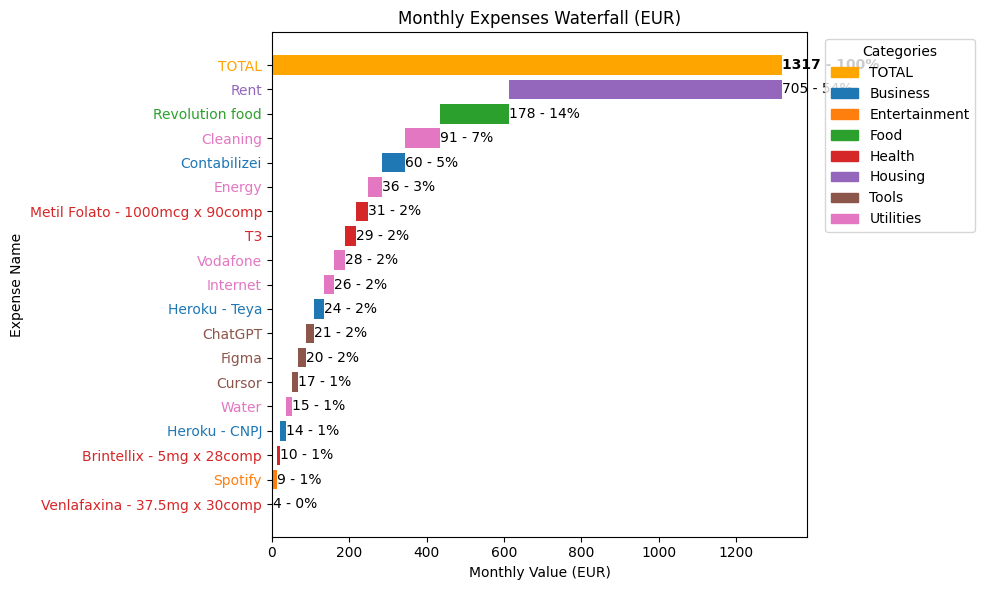

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Create shared category color map based on all unique categories in the dataframe
expense_categories_all = df['category'] if 'category' in df.columns else None
if expense_categories_all is not None:
    unique_categories_all = [cat for cat in pd.unique(expense_categories_all) if pd.notnull(cat)]
    unique_categories_all = sorted(unique_categories_all)
else:
    unique_categories_all = []
available_colors = plt.rcParams["axes.prop_cycle"].by_key().get("color", ["skyblue", "C1", "C2", "C3", "C4", "C5", "C6", "C7"])
category_color_map = {cat: available_colors[i % len(available_colors)] for i, cat in enumerate(unique_categories_all)}

expense_values = df['monthly_value_eur'] if 'monthly_value_eur' in df.columns else df['monthly_value']
expense_names = df['name']
expense_categories = df['category'] if 'category' in df.columns else None

sorted_indices = np.argsort(expense_values.values)
expense_names_sorted = expense_names.values[sorted_indices]
expense_values_sorted = expense_values.values[sorted_indices]
expense_categories_sorted = expense_categories.values[sorted_indices] if expense_categories is not None else ["Other"] * len(expense_names_sorted)

cumulative = np.cumsum(expense_values_sorted) - expense_values_sorted

# Insert TOTAL bar just after the Rent bar (which may not be first)
rent_idx = np.where(expense_names_sorted == "Rent")[0]
if len(rent_idx) == 0:
    insert_at = 0
else:
    insert_at = rent_idx[0] + 1

all_names = list(expense_names_sorted)
all_values = list(expense_values_sorted)
all_cumulative = list(cumulative)
all_categories = list(expense_categories_sorted)

all_names.insert(insert_at, "TOTAL")
all_values.insert(insert_at, expense_values_sorted.sum())
all_cumulative.insert(insert_at, 0)
all_categories.insert(insert_at, "Total")

total_value = expense_values_sorted.sum()

bar_colors = []
for i, cat in enumerate(all_categories):
    if i == insert_at:
        bar_colors.append("orange")
    else:
        bar_colors.append(category_color_map.get(cat, "grey"))

# Prepare label colors to match the bar/category color (except TOTAL)
label_colors = []
for i, cat in enumerate(all_categories):
    if i == insert_at:
        label_colors.append("orange")
    else:
        label_colors.append(category_color_map.get(cat, "grey"))

fig, ax = plt.subplots(figsize=(10, 6))

bars = ax.barh(all_names, all_values, left=all_cumulative, color=bar_colors)

ax.set_xlabel('Monthly Value (EUR)')
ax.set_ylabel('Expense Name')
ax.set_title('Monthly Expenses Waterfall (EUR)')

for i, (bar, value, label_color) in enumerate(zip(bars, all_values, label_colors)):
    percent = int(round(100 * value / total_value)) if total_value > 0 else 0
    label_text = f'{int(round(value))} - {percent}%'
    if i == insert_at:
        ax.text(bar.get_x() + bar.get_width() + 0.05,
                bar.get_y() + bar.get_height() / 2,
                label_text, va='center', ha='left', fontweight='bold')
    else:
        ax.text(bar.get_x() + bar.get_width() + 0.05,
                bar.get_y() + bar.get_height() / 2,
                label_text, va='center', ha='left')

# Color the y-tick labels (expense names) to match their category color
yticks = ax.get_yticklabels()
for i, tick in enumerate(yticks):
    # For TOTAL, orange; otherwise, the correct color by category
    if i < len(label_colors):
        tick.set_color(label_colors[i])

import matplotlib.patches as mpatches

legend_handles = [mpatches.Patch(color=color, label=cat) for cat, color in category_color_map.items()]
legend_handles.insert(0, mpatches.Patch(color="orange", label="TOTAL"))

ax.legend(handles=legend_handles, title="Categories", bbox_to_anchor=(1.02, 1), loc="upper left")

plt.tight_layout()
plt.show(fig)

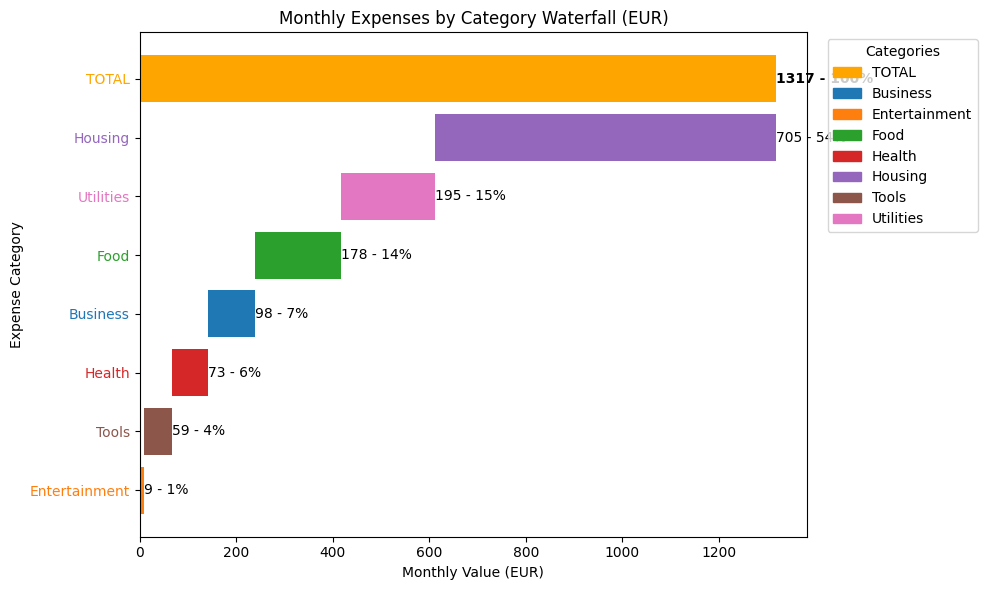

In [4]:
import matplotlib.pyplot as plt
import numpy as np

expense_values = df['monthly_value_eur'] if 'monthly_value_eur' in df.columns else df['monthly_value']
expense_categories = df['category']

# Group by category and sum
category_sums = expense_values.groupby(expense_categories).sum()

# Remove categories with null/empty name (if any)
category_sums = category_sums[category_sums.index.notnull()]

# Sort ascending (smallest to largest)
sorted_indices = np.argsort(category_sums.values)
categories_sorted = category_sums.index.values[sorted_indices]
values_sorted = category_sums.values[sorted_indices]

cumulative = np.cumsum(values_sorted) - values_sorted

# Insert "TOTAL" bar just after "Housing" (as a proxy for "Rent" in old chart)
housing_idx = np.where(categories_sorted == "Housing")[0]
if len(housing_idx) == 0:
    insert_at = 0
else:
    insert_at = housing_idx[0] + 1

all_names = list(categories_sorted)
all_values = list(values_sorted)
all_cumulative = list(cumulative)

all_names.insert(insert_at, "TOTAL")
all_values.insert(insert_at, values_sorted.sum())
all_cumulative.insert(insert_at, 0)

total_value = values_sorted.sum()

bar_colors = []
for i, name in enumerate(all_names):
    if i == insert_at:
        bar_colors.append("orange")
    else:
        bar_colors.append(category_color_map.get(name, "grey"))

# Prepare label colors to match the bar/category color (except TOTAL)
label_colors = []
for i, name in enumerate(all_names):
    if i == insert_at:
        label_colors.append("orange")
    else:
        label_colors.append(category_color_map.get(name, "grey"))

fig, ax = plt.subplots(figsize=(10, 6))

bars = ax.barh(all_names, all_values, left=all_cumulative, color=bar_colors)

ax.set_xlabel('Monthly Value (EUR)')
ax.set_ylabel('Expense Category')
ax.set_title('Monthly Expenses by Category Waterfall (EUR)')

for i, (bar, value, label_color) in enumerate(zip(bars, all_values, label_colors)):
    percent = int(round(100 * value / total_value)) if total_value > 0 else 0
    label_text = f'{int(round(value))} - {percent}%'
    if i == insert_at:
        ax.text(bar.get_x() + bar.get_width() + 0.05,
                bar.get_y() + bar.get_height() / 2,
                label_text, va='center', ha='left', fontweight='bold')
    else:
        ax.text(bar.get_x() + bar.get_width() + 0.05,
                bar.get_y() + bar.get_height() / 2,
                label_text, va='center', ha='left')

# Color the y-tick labels (category names) to match their category color
yticks = ax.get_yticklabels()
for i, tick in enumerate(yticks):
    if i < len(label_colors):
        tick.set_color(label_colors[i])

import matplotlib.patches as mpatches

legend_handles = [mpatches.Patch(color=color, label=cat) for cat, color in category_color_map.items()]
legend_handles.insert(0, mpatches.Patch(color="orange", label="TOTAL"))

ax.legend(handles=legend_handles, title="Categories", bbox_to_anchor=(1.02, 1), loc="upper left")

plt.tight_layout()

plt.show(fig)
